In [1]:
import sys
from pathlib import Path

module_path = Path.cwd().parent
if module_path.as_posix() not in sys.path:
    sys.path.insert(0, Path.cwd().parent.as_posix())

In [2]:
from FreestylePulseOptimization.runners import RuntimeRunner
from FreestylePulseOptimization.runtime.hw_logical2 import (
    HWCI_MatrixSolutionRuntimeLogicalCircuitRunner,
)
import pickle
from typing import Any, Callable, Protocol, Self
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import ticker

In [3]:
base_dir = Path.cwd().parent / "final-results"
base_dir = Path.cwd()

In [4]:
files = list(base_dir.glob("**/*.pkl"))
files

[PosixPath('/home/moroses/gits/FreestylePulseOptimization/example/DATA3.pkl'),
 PosixPath('/home/moroses/gits/FreestylePulseOptimization/example/DATA.pkl'),
 PosixPath('/home/moroses/gits/FreestylePulseOptimization/example/DATA2.pkl')]

In [5]:
datum: dict[str, Any] = {}
for file in files:
    datum[file.name] = pickle.loads(file.read_bytes())

In [ ]:
data = datum[
    "Nt-10|padding-2|total_shots-1000|distance-1.5|phys_to_logical-[50, 150, 50]|additional_data-{'order': 'd1_u1_d1', 'alignment': 'c_s_c'}.2.pkl"
]

In [ ]:
data = datum["DATA.pkl"]

In [ ]:
data = datum['DATA2.pkl']

In [6]:
class RelativeDistanceProtocol(Protocol):
    def __call__(self: Self, a: float, *, calc_distance: bool = True) -> float: ...


def rel_dist(b: float, *, abs_dist: bool = True) -> RelativeDistanceProtocol:
    _f = np.abs if abs_dist else lambda x: x

    def _internal(a: float, *, calc_distance: bool = True) -> float:
        d = a - b if calc_distance else a
        return _f(d) / np.abs(b)

    return _internal


def dist(b: float, *, abs_dist: bool = True) -> RelativeDistanceProtocol:
    _f = np.abs if abs_dist else lambda x: x

    def _internal(a: float, *, calc_distance: bool = True) -> float:
        d = a - b if calc_distance else a
        return _f(d)

    return _internal


def what_dist(b: float, *, abs_dist: bool = True) -> RelativeDistanceProtocol:
    _f = np.abs if abs_dist else lambda x: x

    def _internal(a: float, *, calc_distance: bool = True) -> float:
        d = b - a if not calc_distance else a
        return _f(d)

    return _internal

In [ ]:
sol = data["solution"]

In [7]:
from typing import ParamSpec

P = ParamSpec("P")


def scale(f: Callable[P, float], scale: float) -> Callable[P, float]:
    def _internal(*args: P.args, **kwargs: P.kwargs) -> float:
        return f(*args, **kwargs) * scale

    return _internal

In [8]:
fr = rel_dist(sol.ci_matrix.ci_ground_state_energy)
f = scale(dist(sol.ci_matrix.ci_ground_state_energy, abs_dist=False), 1e3)
ff = dist(sol.ci_matrix.ci_ground_state_energy, abs_dist=True)
f2 = what_dist(sol.ci_matrix.ci_ground_state_energy, abs_dist=False)

NameError: name 'sol' is not defined

In [ ]:
fig, axs = plt.subplot_mosaic(
    [
        ["EE", "zEE"],
        ["EvI", "zEvI"],
        ["dEvI", "zdEvI"],
    ],
    sharex=True,
    figsize=plt.figaspect(1) * (2, 2),
    # [
    #     ['EE', 'EvI', 'dEvI'],
    #     ['EE', 'EvI', 'dEvI'],
    # ]
)

x = np.arange(len(sol.energy_trajectory)) + 1
y = np.array(sol.energy_trajectory)
dy = np.array(sol.energy_error)

Y = np.linspace(y.min(), y.max(), 1_00, endpoint=True)

CA = 0.0016

exact = sol.ci_matrix.ci_ground_state_energy

fig.suptitle(f"Total of {len(x)} iterations")

for ax_name, c_f, ticks, ylbl, top_val in zip(
    ("EE", "EvI", "dEvI"),
    (f2, f, fr),
    (None, None, ticker.PercentFormatter(1.0)),
    ("Energy [Ha]", "Energy difference [mHa]", "Energy difference [%]"),
    (-7.85, 50, 0.01),
):
    # axs[ax_name].errorbar(x, c_f(y), yerr=c_f(dy), marker='.', capsize=2.5)
    for prefix in ("", "z"):
        ax = axs[f"{prefix}{ax_name}"]
        ax.plot(x, c_f(y), marker=".", label="Data")
        if ticks is not None:
            ax.yaxis.set_major_formatter(ticks)

        ax.axhline(
            c_f(sol.ci_matrix.ci_ground_state_energy), color="k", ls=":", label="Exact"
        )
        ax.axvline(
            cobyla := len(sol.parameter_names) * 2, color="r", ls=":", label="COBYLA"
        )
        ax.fill_betweenx(
            c_f(Y),
            x.min(),
            cobyla,
            alpha=0.3,
            color="gray",
            hatch="x",
            label='"Bad" region',
        )
        ax.fill_betweenx(
            c_f(Y),
            cobyla,
            x.max(),
            alpha=0.3,
            color="yellow",
            hatch="o",
            label='"Good" region',
        )
        ax.fill_between(
            x,
            c_f(CA, calc_distance=False),
            c_f(-CA, calc_distance=False),
            alpha=0.3,
            color="g",
            hatch="\\",
            label="CA region",
        )

        ax.set(xlabel="Iteration []", ylabel=ylbl)

        if prefix == "z":
            ax.set_ylim(
                top=top_val,
            )
        else:
            ax.legend()


# ax.set_ylim(0, .005)

fig.tight_layout()

# fig.savefig('../../../LiH-last-run.png', dpi=600, bbox_inches='tight')

plt.show()
plt.close(fig)

In [ ]:
help(ax.legend)

In [ ]:
f"{f(y[best_ind]):.2f}"

In [ ]:
ax.transAxes

In [ ]:
f(y)[22]

In [6]:
from FreestylePulseOptimization.runtime.hw_logical2 import (
    convert_ordered_channels_to_schedule,
    convert_parameters_to_channels_ordered,
)

In [ ]:
sol.additional_data["padding"]

In [ ]:
sol.phys_to_logical

In [ ]:
sol.additional_data['order']

In [ ]:
sol.dt

In [ ]:
from qiskit_dynamics.pulse import InstructionToSignals

In [9]:
from cycler import cycler
from typing import Optional
from qiskit_dynamics import Signal
from collections.abc import Sequence, Mapping
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from numpy.typing import NDArray


def plot_signals(
    signals: Sequence[Signal],
    duration: float,
    *,
    colormap: str = "tab20c",
    num_points: int = 1_00,
    max_y: Optional[float] = None,
    min_y: Optional[float] = None,
    remove_channels: Optional[Sequence[str]] = None,
    fig: Optional[Figure] = None,
    axs: Optional[NDArray[Axes]|Mapping[str|int, Axes]] = None,
    zero_line: Mapping[str, Any] = {'linestyle': 'dotted', 'color': 'k'},
    tight_layout: bool = True,
    axes_map: Optional[Mapping[str, str|int]]=None
) -> tuple[Figure, NDArray[Axes]|Mapping[str|int, Axes]]:
    signal_count = np.array(
        [
            remove_channels is None or signal.name not in remove_channels
            for signal in signals
        ],
        dtype=bool,
    )
    N = sum(signal_count)
    rel_signals = np.array(signals)[np.where(signal_count)[0]]

    if fig is None and axs is None:
        fig, axs = plt.subplots(nrows=N, sharex=True, gridspec_kw=dict(hspace=0))

    if axes_map is None:
        axes_map = dict(zip([signal.name for signal in rel_signals], range(N)))

    colors = plt.get_cmap(colormap, N)(np.linspace(0.0, 1.0, N))
    for i, s in enumerate(rel_signals):
        # if remove_channels is not None and s.name in remove_channels:
        #     continue
        ax = axs[axes_map[s.name]]
        ax.axhline(0, **zero_line)
        transAxes = ax.transAxes
        ax.annotate(
            text=f"{s.name}",
            xy=(-0.1, 0.5),
            xytext=(-2., -.1),
            xycoords=transAxes,
            textcoords="offset fontsize",
        )
        cyc = cycler(color=[colors[i]]) * cycler(linestyle=["-", ":"])
        ax.set_prop_cycle(cyc)
        s.draw(0, duration, num_points, "envelope", axis=ax)
        # axs[i].set_ylim(-.15, .15,)
        ax.set_ylim(
            bottom=min_y,
            top=max_y,
        )
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()

    axs[axes_map[rel_signals[-1].name]].set(xlabel="t [ns]")
    tight_layout and fig.tight_layout()
    return fig, axs

In [ ]:
InstructionToSignals

In [ ]:
s = convert_ordered_channels_to_schedule(
    convert_parameters_to_channels_ordered(
        sol.qubit_spec,
        [("d", 1), ("u", 1), ("d", 1)],
        ["c", "s", "c"],
        [50, 150, 50],
        sol.parameter_names,
        sol.additional_data["padding"],
        sol.additional_data["timing_constraints"],
    )(sol.parameters_trajectory[22])
)

In [10]:
from FreestylePulseOptimization import get_device_parameters, generate_solver

In [11]:
from FreestylePulseOptimization.runners import RuntimeRunner

In [ ]:
runner = RuntimeRunner(
    channel="ibm_quantum", instance="ibm-q/open/main", backend_name="ibm_brisbane"
)

In [ ]:
sol.additional_data["backend_name"]

In [ ]:
qubits, dt = get_device_parameters(runner.backend, (0, 1, 2))

In [ ]:
solver, real2sim, connection_map, signal_maker = generate_solver(qubits, dt, True)

In [ ]:
s.duration * dt

In [ ]:
np.minimum.accumulate(f(y))

In [ ]:
plt.plot(ff(y)+exact)
plt.plot(x[cobyla:], np.minimum.accumulate(ff(y[cobyla:]))+exact)

In [ ]:
fig_data = {
    "x": np.arange(len(y)),
    "y": y,
    "exact": exact,
    "CA": CA,
    "cobyla": cobyla,
}

Y = np.linspace(
    min(exact-CA, fig_data['y'].min()),
    fig_data['y'].max(),
    1_00,
)

fig, ax = plt.subplots(figsize=plt.figaspect(1) * (2, 1))

best_ind = cobyla + ff(y[cobyla:]).argmin()

pretext = "Optimizer's "

labels = [
    f"Freestyle pulse (${s.duration*dt:.0f}~[\\mathrm{{ns}}]$)",
    pretext + "searching region",
    pretext + "convergence region",
    "Chemical accuracy region",
    f"$E_\\mathrm{{FCI}}={exact:.4f}~[Ha]$",
    f"$\\Delta E_\\mathrm{{FCI}}={f(y[best_ind]):.2f}~[\\mathrm{{mHa}}]$",
    'Convergance plot',
]

x = np.arange(len(y))

(data,) = ax.plot("x", "y", data=fig_data, marker=".", label="Data")
exact_line = ax.axhline(fig_data["exact"], color="#c7f6c7", ls=":", label="Exact")
# ax.axvline(cobyla := len(sol.parameter_names) * 2, color="r", ls=":", label='COBYLA')
search_region = ax.fill_betweenx(
    Y,
    x.min(),
    fig_data["cobyla"],
    alpha=0.3,
    color="gray",
    hatch="x",
    # label='"Bad" region',
)
convergance_region = ax.fill_betweenx(
    Y,
    fig_data["cobyla"],
    x.max(),
    alpha=0.9,
    # color="#ffee75",
    # color="white",
    # color='#fffff2',
    color='#f9f1f1',
    hatch="o",
    # label='"Good" region',
)
ca_region = ax.fill_between(
    x,
    fig_data["exact"] - fig_data["CA"],
    fig_data["exact"] + fig_data["CA"],
    alpha=0.3,
    color="#c7f6c7",
    hatch="\\",
    # label="CA region",
)

# TODO Fix this
convergance_data = np.minimum.accumulate(ff(fig_data['y'][cobyla:])) + exact
convergance_data = np.minimum.accumulate(ff(fig_data['y'][cobyla:])) + exact
convergance_plot, = ax.plot(x[cobyla:], convergance_data, color='orange',)

ax.set(xlabel="Iteration []", ylabel="Energy [Ha]")

best_x = fig_data["x"][best_ind]
best_y = fig_data["y"][best_ind]

(best_line,) = ax.plot(best_x, best_y, marker="*", color="r", ls="")

ax.annotate(
    labels[-2],
    xy=(best_x, best_y),
    xycoords=ax.transData,
    xytext=(0.5, 0.5),
    textcoords=ax.transAxes,
    arrowprops=dict(
        arrowstyle="<|-",
    ),
    va="center",
    ha="left",
)
handles = [
    data,
    search_region,
    convergance_region,
    ca_region,
    exact_line,
    best_line,
    convergance_plot,
]

labels[-2] = "_"

leg_handles = [
    handle for handle, label in zip(handles, labels) if not label.startswith("_")
]
leg_labels = [label for label in labels if not label.startswith("_")]

ax.legend(leg_handles, leg_labels)


ax.set_xlim(x.min(), x.max())

ax.set_ylim(min([exact - CA, y.min()]), y.max())
ax.set_ylim(bottom=-7.9)

yticks_major = ticker.MultipleLocator(.1)
yticks_minor = ticker.MultipleLocator(.01)
ax.yaxis.set_major_locator(yticks_major)
ax.yaxis.set_minor_locator(yticks_minor)


fig.tight_layout()

if False:
    file_name = Path.cwd() / "LiH_d=1.5_Nq=3.png"
    fig.savefig(file_name, dpi=600, bbox_inches="tight")
    file_name.with_stem("pkl").write_bytes(pickle.dumps(fig_data))

plt.show()
plt.close(fig)

In [12]:
def abs_dist(a: float) -> Callable[[float], tuple[float, int]]:
    def _internal(b: float) -> tuple[float, int]:
        return np.abs(b-a), np.sign(b-a)
    return _internal

In [ ]:
fff = abs_dist(exact)

In [ ]:
g = np.minimum.accumulate(np.vstack(fff(y[cobyla:])).T, axis=0)

In [ ]:
fff(y[0])

In [ ]:
np.isclose(t:=exact + g[:,1] * g[:,0] , y[cobyla:])

In [ ]:
plt.plot(y[cobyla:])
plt.plot(t)

In [ ]:
np.isclose(exact - g[:,1] * g[:,0],y)

In [ ]:
np.isclose((g[:,0] - g[:,1] * exact) , y)

In [ ]:
g[:,0] - g[:,1] * exact == y

In [ ]:
y[best_ind] - exact

In [ ]:
convergance_data[best_ind - cobyla] - exact

In [ ]:
1e3 * ff(y)[45]

In [ ]:
1e3 * np.minimum.accumulate(ff(y[cobyla:])).min()

In [ ]:
1e3 * (fig_data["y"][-6:].mean() - exact)

In [ ]:
f'{1e3 * sol.energy_error[best_ind]:.2f}'

In [ ]:
sol = datum['DATA.pkl']['solution']

In [ ]:
from FreestylePulseOptimization import PaddingType, TimingConstraints
padding: PaddingType = sol.additional_data['padding']
timing_const: TimingConstraints = sol.additional_data['timing_constraints']

In [ ]:
padding.pad(np.ones((150,)), timing_const).shape

In [11]:
from matplotlib.transforms import blended_transform_factory

In [ ]:
fig, axs = plot_signals(signal_maker(s), s.duration * dt)

ax = axs[0]
trans = blended_transform_factory(ax.transData, ax.transAxes)

ax.annotate(
    xy=(0,.5),
    text='',
    xytext=(50*dt, .5),
    textcoords=trans,
    xycoords=trans,
    arrowprops=dict(arrowstyle='<|-|>', shrinkA=0, shrinkB=0)
)
ax.annotate(
    xy=(50*dt,.5),
    text='',
    xytext=(56*dt, .5),
    textcoords=trans,
    xycoords=trans,
    arrowprops=dict(arrowstyle='<|-|>', shrinkA=0, shrinkB=0)
)
ax.annotate(
    xy=(25*dt,.55),
    text='50dt',
    # xytext=(25*dt, .55),
    textcoords=trans,
    xycoords=trans,
    ha='center',
)
ax.annotate(
    xy=(53*dt,.55),
    text='6dt',
    # xytext=(25*dt, .55),
    textcoords=trans,
    xycoords=trans,
    ha='center',
)
for p in (0, 56*dt):
    ax.axvline(p, color='gray', zorder=-2)

ax = axs[3]
trans = blended_transform_factory(ax.transData, ax.transAxes)

ax.annotate(
    xy=(56*dt,.5),
    text='',
    xytext=((56+150)*dt, .5),
    textcoords=trans,
    xycoords=trans,
    arrowprops=dict(arrowstyle='<|-|>', shrinkA=0, shrinkB=0)
)
ax.annotate(
    xy=((56+150)*dt,.5),
    text='',
    xytext=((56+152)*dt, .5),
    textcoords=trans,
    xycoords=trans,
    arrowprops=dict(arrowstyle='<|-|>', shrinkA=0, shrinkB=0)
)
ax.annotate(
    xy=((56+150/2)*dt,.55),
    text='150dt',
    # xytext=(25*dt, .55),
    textcoords=trans,
    xycoords=trans,
    ha='center',
)
ax.annotate(
    xy=((56+150+1)*dt,.55),
    text='2dt',
    # xytext=(25*dt, .55),
    textcoords=trans,
    xycoords=trans,
    ha='center',
)
for p in (56, 152+56):
    ax.axvline(p*dt, color='gray', zorder=-2)

fig.tight_layout()

In [ ]:
(56+152+152+56)

# Show two experiments
One has 1000 shots and the other has 100

In [13]:
base_dir = Path.cwd()
cur_files = list(base_dir.glob("**/*.pkl"))
cur_files

[PosixPath('/home/moroses/gits/FreestylePulseOptimization/example/DATA3.pkl'),
 PosixPath('/home/moroses/gits/FreestylePulseOptimization/example/DATA.pkl'),
 PosixPath('/home/moroses/gits/FreestylePulseOptimization/example/DATA2.pkl')]

In [14]:
datum = {}
for file in cur_files:
    datum[file.name] = pickle.loads(file.read_bytes())

In [15]:
del datum['DATA3.pkl']

In [16]:
datum['DATA.pkl']

{'solution': HWCI_MatrixSolutionRuntimeLogicalCircuitRunner(ci_matrix=CI_Matrix(mol_name='LiH', distance=1.5, n_dim=8, nuclear_repulsion_energy=1.0583544213400002, ci_ground_state_energy=-7.8823622868109116, matrix=array([[-8.92171204e+00,  1.22953309e-01,  3.34934448e-02,
          3.34934448e-02,  2.33437370e-09,  2.33437370e-09,
          1.21386268e-02,  2.39870437e-02],
        [ 1.22953309e-01, -7.81887101e+00, -2.48202369e-02,
         -2.48202369e-02, -3.10577639e-02, -3.10577639e-02,
          2.63029784e-02,  1.94732102e-02],
        [ 3.34934448e-02, -2.48202369e-02, -8.17786686e+00,
          2.63029784e-02, -8.44455007e-03,  1.41706666e-01,
         -1.04426038e-01,  1.38655674e-02],
        [ 3.34934448e-02, -2.48202369e-02,  2.63029784e-02,
         -8.17786686e+00,  1.41706666e-01, -8.44455007e-03,
         -1.04426038e-01,  1.38655674e-02],
        [ 2.33437370e-09, -3.10577639e-02, -8.44455007e-03,
          1.41706666e-01, -8.76364400e+00,  1.21386268e-02,
          

In [17]:
from collections.abc import Mapping
from typing import Any, NamedTuple, TypedDict
from FreestylePulseOptimization.runtime.utils import HWCI_MatrixSolutionRuntimeLogicalCircuitRunner
from FreestylePulseOptimization.utils import OptimizationTime, CI_Matrix
import numpy as np

class LoadedFile(TypedDict):
    solution: HWCI_MatrixSolutionRuntimeLogicalCircuitRunner
    times: OptimizationTime

class XYTupleType(NamedTuple):
    n_qubits: list[int]
    n_shots: int
    n_iterations: int
    n_parameters: int
    x: np.ndarray[np.dtype[float]]
    y: np.ndarray[np.dtype[float]]
    dy: np.ndarray[np.dtype[float]]
    exact_ci: float

def convert_to_x_y(data: LoadedFile) -> XYTupleType:
    sol: HWCI_MatrixSolutionRuntimeLogicalCircuitRunner = data['solution']
    n_qubits = len(sol.qubit_spec)
    n_shots = sol.additional_data['total_shots']
    y = np.array(sol.energy_trajectory, dtype=float)
    dy = np.array(sol.energy_error, dtype=float)
    n_iterations = len(y)
    x = np.arange(n_iterations)
    ci_matrix: CI_Matrix = sol.ci_matrix
    exact = ci_matrix.ci_ground_state_energy
    n_parameters = len(sol.parameter_names) * 2
    

    return XYTupleType(
        n_qubits,
        n_shots,
        n_iterations,
        n_parameters,
        x,
        y,
        dy,
        exact
    )

In [18]:
datas = list(map(convert_to_x_y, datum.values()))

In [19]:
def calc_energy_error(xy_data: XYTupleType, *, absolute: bool=False) -> XYTupleType:
    f = np.abs if absolute else lambda y: y
    abs_exact = abs(xy_data.exact_ci)
    return XYTupleType(
        xy_data.n_qubits,
        xy_data.n_shots,
        xy_data.n_iterations,
        xy_data.n_parameters,
        xy_data.x,
        f(xy_data.y - xy_data.exact_ci) / abs_exact,
        xy_data.dy / abs_exact,
        xy_data.exact_ci,
    )

In [20]:
from matplotlib.axes import Axes
from typing import TypeAlias, overload, Literal

class AxisLim(NamedTuple):
    min: float
    max: float

class FigExtrema(NamedTuple):
    x: AxisLim
    y: AxisLim
    

class AxesLims(TypedDict):
    xlim: tuple[float, float]
    ylim: tuple[float, float]

def convert_fig_extrema_to_dict(fig_extrema: FigExtrema) -> AxesLims:
    return AxesLims(
        xlim=fig_extrema.x,
        ylim=fig_extrema.y,
    )

from matplotlib.lines import Line2D
from matplotlib.container import ErrorbarContainer

PLOT_LINE: TypeAlias = Line2D | ErrorbarContainer

@overload
def plot_data(ax: Axes, xy_data: XYTupleType, *, accumulated: bool=Literal[True], errors: bool=False) -> tuple[list[PLOT_LINE],FigExtrema]:
    ...
@overload
def plot_data(ax: Axes, xy_data: XYTupleType, *, accumulated: bool=Literal[False], errors: bool=False) -> tuple[PLOT_LINE,FigExtrema]:
    ...
def plot_data(ax: Axes, xy_data: XYTupleType, *, accumulated: bool=False, errors: bool=False) -> tuple[PLOT_LINE|list[PLOT_LINE],FigExtrema]:
    xy_data = calc_energy_error(xy_data, absolute=True)
    ret: PLOT_LINE
    if errors:
        ret = ax.errorbar(
            xy_data.x,
            xy_data.y,
            yerr=xy_data.dy,
            capsize=5,
            marker='.',
        )
    else:
        ret, = ax.plot(
            xy_data.x,
            xy_data.y,
            marker='.',
        )

    fig_extrema = FigExtrema(
                x=AxisLim(
                    min=xy_data.x.min(),
                    max=xy_data.x.max(),
                ),
                y=AxisLim(
                    min=xy_data.y.min(),
                    max=xy_data.y.max(),
                ),
            )

    if not accumulated:
        return ret, fig_extrema

    n_param = xy_data.n_parameters
    accumulated_data = np.minimum.accumulate(xy_data.y[n_param:])
    ret2, = ax.plot(xy_data.x[n_param:], accumulated_data, marker='')
    return [ret, ret2], fig_extrema



In [21]:
from collections.abc import Iterable

def global_fig_extrema(fig_extremas: Iterable[FigExtrema]) -> FigExtrema:
    min_x = min_y = np.inf
    max_x = max_y = -np.inf

    for fig_extrema in fig_extremas:
        if min_x > fig_extrema.x.min:
            min_x = fig_extrema.x.min
        if max_x < fig_extrema.x.max:
            max_x = fig_extrema.x.max
        if min_y > fig_extrema.y.min:
            min_y = fig_extrema.y.min
        if max_y < fig_extrema.y.max:
            max_y = fig_extrema.y.max

    return FigExtrema(
        x=AxisLim(min_x, max_x),
        y=AxisLim(min_y, max_y),
    )

def combined_fig_extrema(fig_extremas: Iterable[FigExtrema]) -> FigExtrema:
    min_x = min_y = -np.inf
    max_x = max_y = np.inf

    for fig_extrema in fig_extremas:
        if min_x < fig_extrema.x.min:
            min_x = fig_extrema.x.min
        if max_x > fig_extrema.x.max:
            max_x = fig_extrema.x.max
        if min_y < fig_extrema.y.min:
            min_y = fig_extrema.y.min
        if max_y > fig_extrema.y.max:
            max_y = fig_extrema.y.max

    return FigExtrema(
        x=AxisLim(min_x, max_x),
        y=AxisLim(min_y, max_y),
    )

fig.get_figheight() = 5.0
fig.get_figwidth() = 9.0
fig.get_figheight() = 5.0
fig.get_figwidth() = 9.0


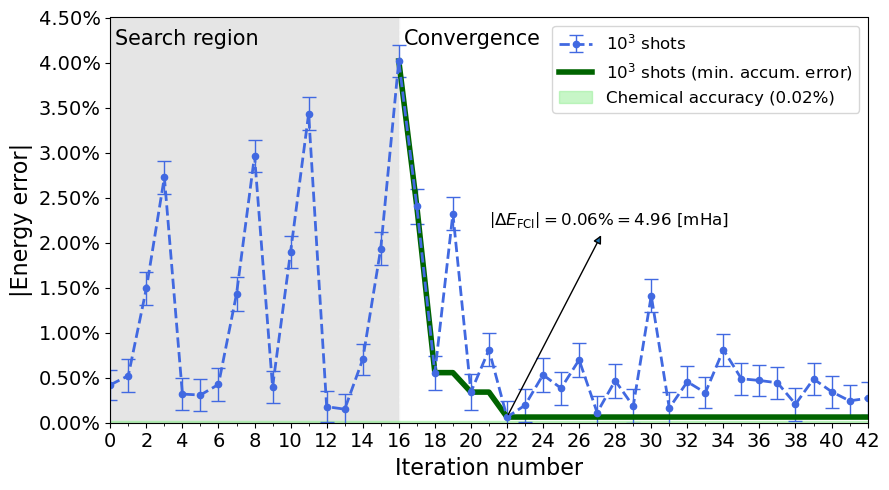

In [23]:
from matplotlib.ticker import PercentFormatter, MultipleLocator

# fig, axs = plt.subplots(figsize=plt.figaspect(1)*(2,1))
fig, axs = plt.subplots(figsize=(1.5*6,5))

CA = 0.0016
exact = datas[0].exact_ci

COBYLA = 16

optimization_line = axs.axvline(COBYLA, color='k')

fig_extremas: list[FigExtrema] = []
lines: list[PLOT_LINE] = []
labels: list[str] = []

plot_colors = ...

errors = (not False, True)
accumulated = (False, True)

for data, error, accumulate in zip(datas[::-1], errors, accumulated):
    line, ext = plot_data(axs, data, errors=error, accumulated=accumulate)
    fig_extremas.append(ext)
    lines.append(line)
    labels.append(
        f"$N_\\mathrm{{shots}}={data.n_shots}$"
    )


axs.set(
    **convert_fig_extrema_to_dict(comb:=combined_fig_extrema(fig_extremas))
)
axs.set(
    **convert_fig_extrema_to_dict(glob:=global_fig_extrema(fig_extremas))
)
# axs.legend(lines, labels)

Y = np.linspace(
    # glob.y.min,
    # glob.y.max,
    0.,
    0.5,
    1_00,
    endpoint=True,
)

search_region = axs.fill_betweenx(
    Y,
    0,
    COBYLA,
    alpha=.4,
)

optim_region = axs.fill_betweenx(
    Y,
    COBYLA,
    glob.x.max,
    alpha=.9,
)

X = np.linspace(
    0,
    glob.x.max,
    1_00,
    endpoint=True,
)
ca_region = axs.fill_between(
    X,
    0,
    CA / abs(datas[0].exact_ci),
    alpha=.4,
)

shots100 = 'blue'
shots1000 = 'cyan'

shots100 = 'red'
# shots100 = 'blue'
shots1000 = 'blue'
# shots1000 = 'cyan'

shots1000 = 'royalblue'
# shots1000 = 'navyblue'
accum = 'darkgreen'
# accum = '#337799'
CAcolor = '#90ee90'

# #shots = 100
# No error
# lines[0].set(
#     # color='#19c994',
#     color=shots100,
#     linewidth=2.5,
#     markersize=9,
#     # visible=False,
# )
        
# Yes error
lines[0].lines[0].set(
    # color='green',
    color=shots100,
    marker='s',
    linewidth=2.,
    markersize=9,
    visible=False,
)
for l in lines[0].lines[1] + lines[0].lines[2]:
    l.set(
        # color='green',
        color=shots100,
        linewidth=1.,
    visible=False,
    )

# #shots = 1000
# Yes error
lines[1][0].lines[0].set(
    # color='green',
    color=shots1000,
    linewidth=2.,
    linestyle='dashed',
    markersize=9,
    # visible=False,
)
for l in lines[1][0].lines[1] + lines[1][0].lines[2]:
    l.set(
        # color='green',
        color=shots1000,
        linewidth=1.,
    )

lines[1][1].set(
    # color='#084d00',
    color=accum,
    # linewidth=2.5,
    linewidth=4,
)

search_region.set(
    color='gray',
    alpha=.2,
    # hatch='x',
)

optim_region.set(
    # color='#f9f1f1',
    color='white',
    # color='red',
    hatch='o',
    alpha=.6,
)

ca_region.set(
    color=CAcolor,
    alpha=.5,
)

optimization_line.set_visible(False)

# for o in (search_region, optim_region):
#     o.set_visible(False)

axs.legend(
    [
        # lines[0],
        lines[1][0],
        lines[1][1],
        # search_region,
        # optim_region,
        ca_region,
    ],
    [
        # r"$10^2$ shots",
        r"$10^3$ shots",
        # r"Freestyle pulse",
        # r"$10^3$ shots (min. accumulated error)",
        r"$10^3$ shots (min. accum. error)",
        # "Optimizer's search region",
        # "Optimizer's optimization region",
        # f"Chemical accuracy region ({CA/abs(datas[0].exact_ci):.2%})",
        f"Chemical accuracy ({CA/abs(datas[0].exact_ci):.2%})",
    ],
fontsize='large',
    # loc='upper right',
    # bbox_to_anchor=(1, .92)
)

best_ind = np.abs((datas[0].y[COBYLA:] - datas[0].exact_ci) / datas[0].exact_ci).argmin() + COBYLA

dE=np.abs((datas[0].y[best_ind]-datas[0].exact_ci)/abs(datas[0].exact_ci))

SCI = -7.881566
dESCI = np.abs((datas[0].y[best_ind]-SCI)/SCI)

annotation_text = f"$\\left|\\Delta E_\\mathrm{{FCI}}\\right|={1e2*dE:.2f}\\%={1e3*dE*np.abs(exact):.2f}~[\\mathrm{{mHa}}]$"
# annotation_text += f"\n"
# annotation_text += f"$\\left|\\Delta E_\\mathrm{{SCI}}\\right|={1e2*dESCI:.2f}\\%={1e3*dESCI*np.abs(SCI):.2f}~[\\mathrm{{mHa}}]$"

axs.annotate(
    xy=(datas[0].x[best_ind], dE),
    text=annotation_text,
    xycoords=axs.transData,
    textcoords=axs.transAxes,
    xytext=(.5, .5),
    arrowprops=dict(
        arrowstyle="<|-",
    ),
    va='center',
    ha='left',
    fontsize='large',
)

axs.annotate(
    xy=(0,1),
    xycoords=axs.transAxes,
    # xytext=(.25,-3.5),
    xytext=(.25,-1.5),
    textcoords='offset fontsize',
    # text="\n".join("Optimizer's search region".split(" ")),
    text="Search region",
    # text="Searching",
    va='bottom',
    fontsize=15,
)

from matplotlib.transforms import blended_transform_factory

t = blended_transform_factory(axs.transData, axs.transAxes)

axs.annotate(
    xy=(COBYLA,1),
    xycoords=t,
    # xytext=(.25,-3.5),
    xytext=(.25,-1.5),
    textcoords='offset fontsize',
    # text='\n'.join("Optimizer's convergence region".split(' ')),
    text="Convergence",
    va='bottom',
    fontsize=15,
)

axs.set_xlim(*comb.x)

axs.set_ylim(0, .045)

axs.yaxis.set_major_formatter(PercentFormatter(1.))
axs.set(
    xlabel='Iteration number',
    ylabel='|Energy error|',
)
axs.xaxis.label.set(fontsize=16)
axs.yaxis.label.set(fontsize=16)
axs.xaxis.set_major_locator(MultipleLocator(2))
axs.xaxis.set_minor_locator(MultipleLocator(1))
axs.xaxis.set_tick_params(labelsize=14)
axs.yaxis.set_tick_params(labelsize=14)
print(f"{fig.get_figheight() = }\n{fig.get_figwidth() = }")
fig.tight_layout()
print(f"{fig.get_figheight() = }\n{fig.get_figwidth() = }")
# fig.savefig("/home/moroses/WinHome/Desktop/LiH_2-b.png", dpi=600, bbox_inches='tight')
# fig.savefig("/home/moroses/WinHome/Desktop/LiH_final.pdf", bbox_inches='tight')
plt.show()
plt.close(fig)

In [ ]:
sol.additional_data['order']

In [56]:

from FreestylePulseOptimization import PaddingType, TimingConstraints, QubitSpecification, generate_solver
from FreestylePulseOptimization.runtime.hw_logical2 import convert_ordered_channels_to_schedule, convert_parameters_to_channels_ordered
from FreestylePulseOptimization.runtime.utils import compose
from qiskit_dynamics.signals import Signal 

def generate_pulse_drawer(file_data: LoadedFile, alignment_str: str) -> Callable[[int], tuple[Sequence[Signal], float]]:
    solution = file_data['solution']
    dt = solution.dt * 1e9 # In ns
    qubit_spec: list[QubitSpecification] = solution.qubit_spec
    additional_data = solution.additional_data if solution.additional_data else {}
    parameter_names = solution.parameter_names
    # TODO FIXME Make this more robust
    order_str = additional_data.get('order', None)
    order = [
        (p[0].lower(), int(p[1:]))
        for p in order_str.split('-')
    ]
    alignment = alignment_str.split('-')
    padding: PaddingType = additional_data.get('padding', PaddingType.NO)
    timing_const: TimingConstraint = additional_data.get('timing_constraints', None)
    phys_to_logical: list[int] = solution.phys_to_logical

    *_, signal_maker = generate_solver(qubit_spec, dt, cross_talk=True)

    f = compose(
        signal_maker,
        convert_ordered_channels_to_schedule,
        convert_parameters_to_channels_ordered(
            qubit_spec,
            order,
            alignment,
            phys_to_logical,
            parameter_names,
            padding,
            timing_const
        )
    )

    trajectory: list[list[complex]] = solution.parameters_trajectory


    def _internal(index: int) -> tuple[Sequence[Signal], float]:
        return (signals:=f(trajectory[index])), max([
            signal.duration
            for signal in signals
        ]) * dt
    return _internal


In [57]:
pulse_original_length = np.array([50, 150, 150, 50])
sol = datum['DATA.pkl']['solution']
padding = sol.additional_data['padding']
timing_const = sol.additional_data['timing_constraints']
real_length = np.fromiter((
    len(padding.pad(np.ones((l,)), timing_const))
    for l in pulse_original_length
), dtype=int)

In [ ]:
np.cumsum(real_length)

In [151]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLineCollection
from matplotlib.collections import LineCollection

class HandlerColorLines(HandlerLineCollection):
    def create_artists(self, legend, artist ,xdescent, ydescent,
                        width, height, fontsize,trans):
        if not isinstance(artist, Iterable) and not all([isinstance(a, Line2D) for a in artist]):
            raise ValueError(f'{self.__class__.__name__}: Wrong artist type! {artist=}')
        N =len(artist)
        # x = np.linspace(0,width,self.get_numpoints(legend)+1)
        x = np.linspace(0,width,N+1)
        # y = np.zeros(self.get_numpoints(legend)+1)+height/2.-ydescent
        y = np.full(N+1, height/2. - ydescent)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        colors = [
            art.get_color()
            for art in artist
        ]
        lc = LineCollection(segments, #cmap=artist.cmap,
        colors=colors,
                     transform=trans)
        linewidth = np.mean(
            [
                art.get_linewidth()
                for art in artist
            ]
        )
        linestyle = artist[0].get_linestyle()
        lc.set_array(x)
        # lc.set_linewidth(artist.get_linewidth())
        lc.set_linewidth(linewidth)
        lc.set_linestyle(linestyle)
        return [lc]


In [185]:
[
    *([.5, 1],) * len(signals)
]

[[0.5, 1], [0.5, 1], [0.5, 1], [0.5, 1], [0.5, 1]]

/tmp/ipykernel_2786/556772104.py:108: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


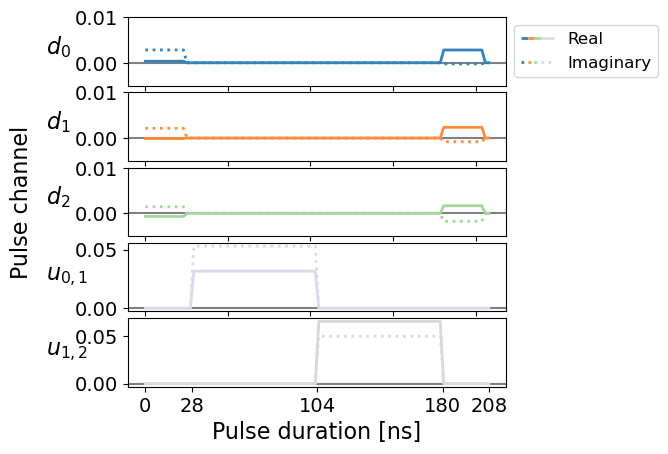

In [207]:
signals, duration = generate_pulse_drawer(datum['DATA.pkl'], 'c-s-c')(best_ind)
fig, axs = plt.subplots(
    nrows=5,
    # figsize=plt.figaspect(1) * (1, 5),
    gridspec_kw={'hspace':.1},
    sharex=True
)
plt.close(fig)

signal_names = [signal.name for signal in signals]
fig, axs = plt.subplot_mosaic(
    mosaic=[
        ['channel', signal.name]
        for signal in signals
    ],
    width_ratios=[
        .05, 1
    ],
    gridspec_kw={'hspace': .1, 'wspace': .5}
)
axes_map = dict(zip(signal_names, signal_names))
fig, axs = plot_signals(
signals, 
duration,
# min_y=-.01,
# max_y=.07,
zero_line={
    'linestyle': 'solid',
    'color': 'gray',
},
fig=fig,
axs=axs,
tight_layout=False,
axes_map=axes_map
)
new_label = {
    'd0': r'$d_0$',
    'd1': r'$d_1$',
    'd2': r'$d_2$',
    'u1': r'$u_{0,1}$',
    'u3': r'$u_{1,2}$',
}

from matplotlib.ticker import FixedLocator

dt = datum['DATA.pkl']['solution'].dt * 1e9
    
x_tick_locator = FixedLocator([0,] + np.cumsum(real_length * dt).tolist())

# for a in axs:
#     a.xaxis.set_major_locator(x_tick_locator)
axs[signal_names[-1]].xaxis.set_major_locator(x_tick_locator)
axs[signal_names[-1]].set_xlabel('Pulse duration [ns]', fontsize=16)

for s in signal_names[:3]:
    a = axs[s]
    a.set_ylim(-.005, 0.01)

real_lines: list[Line2D] = []
imag_lines: list[Line2D] = []

for s in signal_names:
    a = axs[s]
    for t in a.texts:
        if (k:=t.get_text()) in new_label.keys():
            t.set_text(new_label[k])
            t.set(fontsize=16)
    for l in a.lines[1:]:
        l.set(linewidth=2)
    real_lines.append(a.lines[1])
    imag_lines.append(a.lines[2])
    a.xaxis.set_tick_params(labelsize=14)
    a.yaxis.set_tick_params(labelsize=14)
    
# axs[0].legend(loc='upper left', bbox_to_anchor=(1,1))
axs[signal_names[0]].legend(
    loc='upper left',
    bbox_to_anchor=(1,1),
    handles=[real_lines, imag_lines],
    labels=['Real', 'Imaginary'],
    handler_map={
        type(real_lines): HandlerColorLines(),
        # imag_lines: HandlerColorLineCollection(numpoints=5),
        },
        fontsize='large',
)

axs['channel'].annotate(
    xy=(0,.5),
    text='Pulse channel',
    rotation=90,
    fontsize=16,
    va='center',
)

axs['channel'].axis('off')
    
# axs[-1].annotate(
#     xy=(-0.01,.5),
#     xycoords='figure fraction',
#     text='Pulse channel',
#     rotation=90,
#     ha='left',
#     va='center',
#     fontsize='large',
# )

fig.tight_layout()
# fig.tight_layout(rect=[0, 0, .95, 1])
fig.savefig('/home/moroses/WinHome/Desktop/LiH_pulse.pdf', bbox_inches='tight')

In [127]:
a.lines

<Axes.ArtistList of 3 lines>

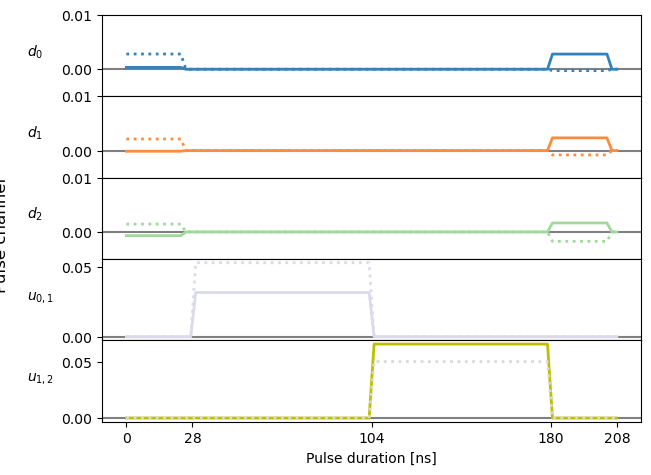

In [98]:
a.lines[1].set(color='y')
fig

In [ ]:
a.lines[0].set_visible(False)

In [ ]:
fig

In [ ]:
axs.transData

In [ ]:
exact - SCI

In [ ]:
np.abs((datas[0].y - datas[0].exact_ci) / datas[0].exact_ci).argmin()

In [ ]:
d, dd = datas[0].y[22] - datas[0].exact_ci, datas[0].dy[22]

In [ ]:
1e3 * d

In [ ]:
import json
(Path.cwd() / 'best.json').write_text(json.dumps({
    'd': d,
    'dd': dd,
}), encoding='utf-8')

In [ ]:
f'{(datas[0].y[22] - datas[0].exact_ci) / abs(datas[0].exact_ci):.2%}'

In [ ]:
f'{CA / abs(datas[0].exact_ci):.2%}'

In [ ]:
lines[1][0].lines[-1][0].set()

In [ ]:
fig_extremas[0][0].__class__.__mro__

In [ ]:
Line2D.__mro__

In [ ]:
global_fig_extrema(fig_extremas)

In [ ]:
combined_fig_extrema(fig_extremas)

In [ ]:
fig, axs = plt.subplots(figsize=plt.figaspect(1)*(2,1))

for file in sorted(Path.cwd().glob("DATA*.pkl"), key=lambda f: f.name):
    
    dd: LoadedFile = pickle.loads(file.read_bytes())
    print(dd['solution'].phys_to_logical)
    p_dd = convert_to_x_y(dd)
    plot_data(axs, p_dd)

plt.show()
plt.close(fig)